<a href="https://colab.research.google.com/github/tramanh1511/AuctionApp/blob/main/RESNET50_Tu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from PIL import Image


from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from google.colab.patches import cv2_imshow

Mounted at /content/drive


In [15]:
import pickle
import matplotlib.pyplot as plt
import cv2

with open('CASME_OF3.pkl', 'rb') as f:
    image_list_loaded, label_list_loaded = pickle.load(f)
#hiển thị 5 ảnh đầu tiên)
# for i in range(15):
#     img = image_list_loaded[i]
#     label = label_list_loaded[i]
#     # Hiển thị ảnh
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Chuyển đổi từ BGR (OpenCV) sang RGB (matplotlib)
#     plt.title(f"Nhãn: {label}")  # Hiển thị nhãn
#     plt.axis('off')  # Tắt trục
#     plt.show()

In [3]:
import pandas as pd

# Đường dẫn tới file CASME2-coding-updated.xlsx
excel_path = '/content/CASME2-coding-20140508.xlsx'

# Đọc file Excel
df = pd.read_excel(excel_path, dtype=str)

# Xem dữ liệu
print(df.head())

# Lọc chỉ các cột cần thiết
df_filtered = df[['Subject', 'Filename', 'ApexFrame', 'Estimated Emotion']]
print(df_filtered.head())


  Subject  Filename Unnamed: 2 OnsetFrame ApexFrame OffsetFrame Unnamed: 6  \
0      01  EP02_01f        NaN         46        59          86        NaN   
1      01   EP03_02        NaN        131       139         161        NaN   
2      01   EP04_02        NaN         21        54          76        NaN   
3      01   EP04_03        NaN         31        41          56        NaN   
4      01   EP04_04        NaN         23        49          66        NaN   

  Action Units Estimated Emotion  
0           12         happiness  
1           18            others  
2            4            others  
3            4            others  
4            4            others  
  Subject  Filename ApexFrame Estimated Emotion
0      01  EP02_01f        59         happiness
1      01   EP03_02       139            others
2      01   EP04_02        54            others
3      01   EP04_03        41            others
4      01   EP04_04        49            others


In [4]:
filtered_df = df_filtered[~df_filtered['Estimated Emotion'].isin(['fear', 'sadness'])] #, 'Disgust'])]
print(filtered_df.shape)
filtered_df.head()

(246, 4)


,Subject,Filename,ApexFrame,Estimated Emotion
0,01,EP02_01f,59,happiness
1,01,EP03_02,139,others
2,01,EP04_02,54,others
3,01,EP04_03,41,others
4,01,EP04_04,49,others


In [5]:
filtered_df = filtered_df[~filtered_df['ApexFrame'].isin(['/'])]
print(filtered_df.shape)
filtered_df.head()

(245, 4)


,Subject,Filename,ApexFrame,Estimated Emotion
0,01,EP02_01f,59,happiness
1,01,EP03_02,139,others
2,01,EP04_02,54,others
3,01,EP04_03,41,others
4,01,EP04_04,49,others


In [ ]:
# image_to_label = []
# # input_path = "/kaggle/input/dynamic-image-cropped-ver-1/Dynamic_Image_ver1_Cropped"
# # input_path = "/kaggle/input/dynamic-image-ver-2/DynamicImagever2_Cropped"
# # input_path = '/kaggle/input/cropped/Cropped'
# # "/kaggle/input/opticalflowcropped/Cropped_OF"
# # of_input_path = "/kaggle/input/opticalflowcropped/OpticalFlowCropped_ver2"
# # input_path = '/kaggle/input/samm-cropped/SAMM_Cropped'
# # '/kaggle/input/samm-di-with-2-versions/SAMM_cropped_DIver2'
# # '/kaggle/input/samm-optical-flow/SAMM'
# # input_path = '/kaggle/input/of-magnitude/OpticalFLowMagni'
# input_path = '/kaggle/input/ofver3/OFVer3'
# for i, row in filtered_df.iterrows():
#     folder_path = os.path.join(input_path, f"sub{row['Subject']:02}/{row['Filename']}")
#     label = row['Estimated Emotion']

#     # Define the specific file name to process
#     # file_name = 'dynamic.png'
#     # file_name = f"reg_img{row['ApexFrame']}.jpg"
#     file_name = "ver3_magni.jpg"
#     # file_name = "onset2apex_magni.jpg"
#     # file_name = getFileName(row, folder_path)
#     # file_name = "dynamic1.png"
#     image_path = os.path.join(folder_path, file_name)
#     # print(file_name)

#     # Check if the file exists before adding it to the list
#     if os.path.exists(image_path):
#         image_to_label.append({'Path': image_path, 'Label': label})
#         # print("path", image_path)
#     else:
#         print("error path", image_path)

AttributeError: 'list' object has no attribute 'shape'

In [16]:
# Chuyển đổi dữ liệu sang dạng numpy array
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import numpy as np

# filtered_images = image_list_loaded
# filtered_labels = label_list_loaded
# X = np.array(filtered_images)
# y = np.array(filtered_labels)

import cv2
import numpy as np

# Assuming filtered_images is your list of images
filtered_images = image_list_loaded
filtered_labels = label_list_loaded

# Get the shape of the first image as a reference
target_shape = filtered_images[0].shape

# Resize all images to the target shape
resized_images = [cv2.resize(image, (target_shape[1], target_shape[0]))
                   if image.shape != target_shape else image
                   for image in filtered_images]

# Now convert the resized images to a NumPy array
X = np.array(resized_images)
Y = np.array(filtered_labels)

# Nếu y là chuỗi (text), cần mã hóa nó thành dạng số trước
# Ví dụ, nếu y chứa các giá trị cảm xúc dạng text như 'happy', 'sad', có thể sử dụng LabelEncoder

# Mã hóa nhãn
le = LabelEncoder()
labels_encoded = le.fit_transform(filtered_labels)
num_classes = len(np.unique(labels_encoded))
class_names = le.classes_
# Count the occurrences of each label type
label_counts = Counter(labels_encoded)
# Print the label counts
for label, count in label_counts.items():
    print(f"{label}: {count}")

# Chuyển đổi sang numpy array
# X = np.array(filtered_images)
y = np.array(labels_encoded)

# indices_to_drop = [80, 86, 92, 115, 135, 139, 140, 141, 169, 170, 193, 223, 224, 228, 247]
# print(X.shape)
# X = np.delete(X, indices_to_drop, axis=0)
# y = np.delete(y, indices_to_drop, axis=0)
# print(X.shape)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1: 32
2: 99
0: 62
3: 27
4: 25


In [17]:
# Define transformation for PyTorch
class CASMEDataset(Dataset):
    def __init__(self, images, labels, transform=None, augment_factor=10):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.augment_factor = augment_factor

    def __len__(self):
        return len(self.images) * self.augment_factor

    def __getitem__(self, idx):
        original_idx = idx % len(self.images)
        augmentation_idx = idx // len(self.images)
        image = self.images[original_idx]
        label = self.labels[original_idx]

        # Convert to PIL format if it's a NumPy array
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        # Apply deterministic transformations based on augmentation index
        augmentation_transforms = [
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation(degrees=5),
            transforms.RandomRotation(degrees=360-5),
            transforms.RandomRotation(degrees=10),
            transforms.RandomRotation(degrees=360-10),
        ]

        # Apply transformation if specified
        if augmentation_idx < len(augmentation_transforms):
            transform = augmentation_transforms[augmentation_idx % len(augmentation_transforms)]
            image = transform(image)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations without negative values for RandomRotation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tạo Dataset
# Create augmented dataset and DataLoader for training
train_dataset_augmented = CASMEDataset(X_train, y_train, transform=data_transforms, augment_factor=15)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True, num_workers=2)

# Create DataLoader for testing
test_dataset = CASMEDataset(X_test, y_test, transform=data_transforms, augment_factor=1)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check data shapes
print(f"Train data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")

print(f"Train dataset size: {len(train_dataset_augmented)}")
print(f"Test dataset size: {len(test_dataset)}")

Train data shape: (196, 282, 231, 3), Test data shape: (49, 282, 231, 3)
Train labels shape: (196,), Test labels shape: (49,)
Train dataset size: 2940
Test dataset size: 49


In [9]:
print(num_classes)

5


In [18]:

# Sử dụng mô hình VGG19 đã được tiền huấn luyện trên ImageNet
model_OF3 = models.resnet50(pretrained=True)

# Đóng băng toàn bộ các tham số trước
for param in model_OF3.parameters():
    param.requires_grad = False

# Chuyển đổi các tham số thành danh sách
params = list(model_OF3.parameters())

# Mở khóa (unfreeze) 4 lớp cuối cùng
for param in params[-4:]:
    param.requires_grad = True

# Thay thế lớp classifier để phù hợp với số lớp của chúng ta
# model.classifier = nn.Sequential(
#     nn.Linear(25088, 4096),
#     nn.ReLU(),
#     nn.Dropout(0.8),
#     nn.Linear(4096, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.8),
#     nn.Linear(1024, num_classes)
# )

model_OF3.fc = nn.Sequential(
    nn.Linear(2048, 4096),  # ResNet50 có đầu ra là 2048
    nn.ReLU(),
    nn.Dropout(0.8),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.8),
    nn.Linear(1024, num_classes)
)


print(num_classes)

# Sử dụng GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_OF3.to(device)

# Calculate class weights
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {label: total_samples / count for label, count in class_counts.items()}
weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float)

# Define loss with class weights
criterion = nn.CrossEntropyLoss(weight=weights).to(device)

# Chỉ tối ưu các tham số trong phần classifier
optimizer = optim.Adam(model_OF3.parameters(), lr=1e-4)

def train_model(model, criterion, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)

        # Đặt gradient về 0
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + Optimize
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        # Thống kê
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

def evaluate_model(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Tắt gradient để tiết kiệm bộ nhớ
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)

            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Thống kê
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

num_epochs = 50

best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Huấn luyện
    train_loss, train_acc = train_model(model_OF3, criterion, optimizer, train_loader_augmented, device)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

    # Đánh giá
    val_loss, val_acc = evaluate_model(model_OF3, criterion, test_loader, device)
    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Lưu mô hình tốt nhất
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), f'best_model_{best_acc:.4f}.pth')
print(f'Best Accuracy: {best_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


5
Epoch 1/50
----------
Train Loss: 1.6525 Acc: 0.2599
Val Loss: 1.6270 Acc: 0.1224
Epoch 2/50
----------
Train Loss: 1.6221 Acc: 0.2592
Val Loss: 1.6170 Acc: 0.2245
Epoch 3/50
----------
Train Loss: 1.5974 Acc: 0.2765
Val Loss: 1.5843 Acc: 0.2449
Epoch 4/50
----------
Train Loss: 1.5351 Acc: 0.3054
Val Loss: 1.5609 Acc: 0.2857
Epoch 5/50
----------
Train Loss: 1.4733 Acc: 0.3466
Val Loss: 1.4851 Acc: 0.3673
Epoch 6/50
----------
Train Loss: 1.3970 Acc: 0.3786
Val Loss: 1.4389 Acc: 0.3878
Epoch 7/50
----------
Train Loss: 1.3198 Acc: 0.4085
Val Loss: 1.4928 Acc: 0.4082
Epoch 8/50
----------
Train Loss: 1.2378 Acc: 0.4537
Val Loss: 1.3926 Acc: 0.3673
Epoch 9/50
----------
Train Loss: 1.1548 Acc: 0.4864
Val Loss: 1.4590 Acc: 0.3265
Epoch 10/50
----------
Train Loss: 1.1116 Acc: 0.5031
Val Loss: 1.5123 Acc: 0.3673
Epoch 11/50
----------
Train Loss: 1.0484 Acc: 0.5371
Val Loss: 1.6453 Acc: 0.3265
Epoch 12/50
----------
Train Loss: 1.0032 Acc: 0.5575
Val Loss: 1.5896 Acc: 0.2857
Epoch 13/50

# Confusion Matrix

Confusion Matrix:
[[5 0 3 0 0]
 [1 1 0 2 0]
 [9 2 8 0 4]
 [2 2 2 2 0]
 [1 0 3 1 1]]

Classification Report:
              precision    recall  f1-score   support

       happy       0.28      0.62      0.38         8
      others       0.20      0.25      0.22         4
     disgust       0.50      0.35      0.41        23
  repression       0.40      0.25      0.31         8
    surprise       0.20      0.17      0.18         6

    accuracy                           0.35        49
   macro avg       0.32      0.33      0.30        49
weighted avg       0.39      0.35      0.35        49



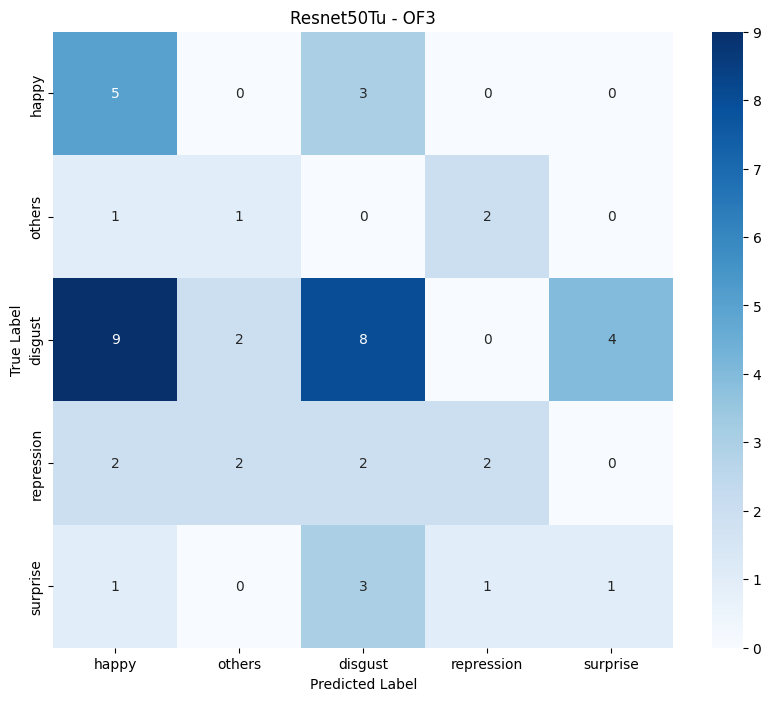

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Hàm đánh giá và in báo cáo
def evaluate_and_report(model, dataloader, device, class_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Ánh xạ lại class i với label
    mapped_preds = [class_mapping[str(p)] for p in all_preds]
    mapped_labels = [class_mapping[str(l)] for l in all_labels]

    # Confusion Matrix
    cm = confusion_matrix(mapped_labels, mapped_preds)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    report = classification_report(mapped_labels, mapped_preds, target_names=list(class_mapping.values()))
    print("\nClassification Report:")
    print(report)

    # Vẽ Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(class_mapping.values()), yticklabels=list(class_mapping.values()))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Resnet50Tu - OF3')
    plt.show()

# Giả sử bạn có ánh xạ nhãn lớp
class_mapping = {
    '1': 'happy',
    '2': 'others',
    '0': 'disgust',
    '3': 'repression',
    '4': 'surprise',
}

# Đánh giá trên tập kiểm tra
evaluate_and_report(model_OF3, test_loader, device, class_mapping)


# Mô hình best model

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from torchvision import models

# Giả sử mô hình và dữ liệu đã được khai báo
# Đảm bảo bạn đã định nghĩa đúng num_classes, device, test_loader và các phần khác

# Khôi phục mô hình tốt nhất
bestmodel_OF3 = models.resnet50(pretrained=True)

# Đóng băng toàn bộ các tham số trước
for param in bestmodel_OF3.parameters():
    param.requires_grad = False

# Khôi phục lại các lớp cuối cùng
bestmodel_OF3.fc = nn.Sequential(
    nn.Linear(2048, 4096),
    nn.ReLU(),
    nn.Dropout(0.8),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.8),
    nn.Linear(1024, num_classes)
)

# Đảm bảo bạn đã chuyển mô hình về đúng device (CPU hoặc GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bestmodel_OF3.to(device)

# Tải lại trọng số của mô hình tốt nhất
bestmodel_OF3.load_state_dict(torch.load(f'best_model_{best_acc:.4f}.pth'))
bestmodel_OF3.eval()  # Đặt mô hình vào chế độ đánh giá


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-20-152d193f7bbb>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Confusion Matrix:
[[ 2  0  5  0  1]
 [ 2  0  1  0  1]
 [ 5  1 14  0  3]
 [ 1  1  2  3  1]
 [ 0  0  4  0  2]]

Classification Report:
              precision    recall  f1-score   support

       happy       0.20      0.25      0.22         8
      others       0.00      0.00      0.00         4
     disgust       0.54      0.61      0.57        23
  repression       1.00      0.38      0.55         8
    surprise       0.25      0.33      0.29         6

    accuracy                           0.43        49
   macro avg       0.40      0.31      0.32        49
weighted avg       0.48      0.43      0.43        49



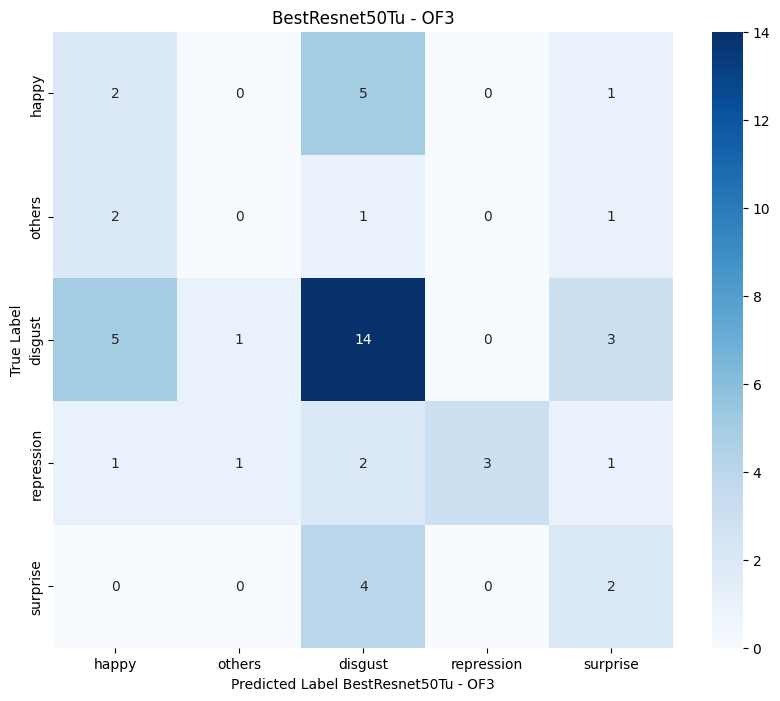

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Hàm đánh giá và in báo cáo
def evaluate_and_report(model, dataloader, device, class_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Ánh xạ lại class i với label
    mapped_preds = [class_mapping[str(p)] for p in all_preds]
    mapped_labels = [class_mapping[str(l)] for l in all_labels]

    # Confusion Matrix
    cm = confusion_matrix(mapped_labels, mapped_preds)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    report = classification_report(mapped_labels, mapped_preds, target_names=list(class_mapping.values()))
    print("\nClassification Report:")
    print(report)

    # Vẽ Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(class_mapping.values()), yticklabels=list(class_mapping.values()))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label BestResnet50Tu - OF3')
    plt.title('BestResnet50Tu - OF3')
    plt.show()

# Giả sử bạn có ánh xạ nhãn lớp
class_mapping = {
    '1': 'happy',
    '2': 'others',
    '0': 'disgust',
    '3': 'repression',
    '4': 'surprise',
}

# Đánh giá trên tập kiểm tra
evaluate_and_report(bestmodel_OF3, test_loader, device, class_mapping)
